In [3]:
!pip install ipympl --user

  Using cached ipympl-0.9.2-py2.py3-none-any.whl (510 kB)
  Using cached matplotlib-3.6.1-cp38-cp38-win_amd64.whl (7.2 MB)


In [27]:
!pip install gym

  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
    Preparing wheel metadata: started
    Preparing wheel metadata: finished with status 'done'
  Created wheel for gym: filename=gym-0.26.2-py3-none-any.whl size=827633 sha256=13014e6268fdb14977d6bf2a5b67da5fb912bb9f3f2253f912fea4bed2d7e773
  Stored in directory: c:\users\максимилиан\appdata\local\pip\cache\wheels\17\79\65\7afedc162d858b02708a3b8f7a6dd5b1000dcd5b0f894f7cc1
Successfully built gym


In [83]:
from casadi import *
%matplotlib widget
import matplotlib.pyplot as plt
#%matplotlib inline

In [84]:
t = SX.sym('t')
l = SX.sym('l',2)
m = SX.sym('m',3)
phi = SX.sym('phi',3)
dphi = SX.sym('dphi',3)

G = SX.sym('g')
g = vcat([0,G])

u = SX.sym('u')
f = vcat([u,0,0])


In [85]:
P1 = vcat([phi[0],0])
P2 = vcat([l[0] * cos(phi[1]), l[0] * sin(phi[1])]) + P1
P3 = vcat([l[1] * cos(phi[2]), l[1] * sin(phi[2])]) + P2
P = horzcat(P1,P2,P3)

J1 = jacobian(P1,phi)
J2 = jacobian(P2,phi)
J3 = jacobian(P3,phi)
J = [J1,J2,J3]

T = SX([0])
U = SX([0])
for i in range(3):
    T += m[i]/2 *(J[i] @ dphi).T @ J[i] @ dphi 
    U += m[i] * g.T @ P[:,i]

def diff_time(J,x,dx):
    J_dot = []
    for vect in horzsplit(J):
        J_dot.append(jacobian(vect,x) @ dx)
    J_dot = hcat(J_dot)
    return J_dot

J1_dot = diff_time(J1,phi,dphi)
J2_dot = diff_time(J2,phi,dphi)
J3_dot = diff_time(J3,phi,dphi)
J_dot = [J1_dot,J2_dot,J3_dot]

A = SX(3,3)
B = SX(3,3)
C = SX(3,3)
D = SX(3,2)
for i in range(3):
    A += m[i] * (J_dot[i].T @ J[i] + J[i].T @ J_dot[i])
    B += m[i] * (J[i].T @ J[i])
    C += m[i] * (J_dot[i].T @ J[i])
    D += m[i] * (J[i].T)
rhs = solve(B,(f + (C - A) @ dphi - D @ g))
rhs = vertcat(dphi,rhs)

m_real = SX([1,1,1])
l_real = SX([1,1])
G_real = SX([10])

my_rhs = substitute([rhs],[m,l,G],[m_real,l_real,G_real])[0]
my_rhs = Function('rhs',[phi,dphi,u],[my_rhs])

energy = substitute([T + U],[m,l,G],[m_real,l_real,G_real])[0]
energy = Function('energy',[phi,dphi],[energy])

my_P = substitute([P],[m,l],[m_real,l_real])
my_P = Function('P',[phi],my_P)

In [86]:
from scipy import integrate
def get_next_state(state,u,dt):
    return integrate.odeint(lambda x,t: my_rhs.call([x[:3],x[3:],[u]])[0].T.full()[0] , state, [0,dt])[1]
def state_to_coords(state):
    return my_P.call([state[:3]])[0].full()
def get_energy(state):
     return energy.call([state[:3],state[3:]])[0].full()[0]

In [87]:
dt = 0.01
state0 = np.array([0,0,0,
                0,0,0])
state = state0 # global var

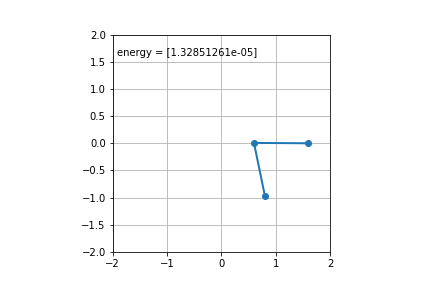

In [88]:
import matplotlib.animation as animation
import matplotlib.pyplot as plt
%matplotlib widget
fig = plt.figure()
ax = fig.add_subplot(111, aspect='equal', autoscale_on=False,
                     xlim=(-2, 2), ylim=(-2, 2))
ax.grid()

line, = ax.plot([], [], 'o-', lw=2)
energy_text = ax.text(0.02, 0.90, '', transform=ax.transAxes)

def init():
    """initialize animation"""
    line.set_data([], [])
    #time_text.set_text('')
    energy_text.set_text('')
    return line

def animate(i):
    """perform animation step"""
    global state, dt
    state = get_next_state(state,0,dt)
    XY = state_to_coords(state)
    en = get_energy(state)
    
    line.set_data(XY[0],XY[1])
    energy_text.set_text(f'energy = {en}')
    return line,

ani = animation.FuncAnimation(fig, animate, frames=300,
                              interval=20, blit=True, init_func=init)
from IPython.display import HTML
HTML(ani.to_jshtml())

# Actor-critic

In [89]:
from torch import nn
import torch
from torch.utils.tensorboard import SummaryWriter
import gym
from torch.distributions import Normal
from gym.spaces import Box
import random
from IPython.display import clear_output

In [90]:
dt = 0.01
state0 = np.array([0,np.pi/2,np.pi/2,
                0,0,0])
state = state0 # global var


In [91]:
state_to_coords(state)

array([[0.00000000e+00, 6.12303177e-17, 1.22460635e-16],
       [0.00000000e+00, 1.00000000e+00, 2.00000000e+00]])

Soft actor-critic

https://github.com/vaishak2future/sac/blob/master/sac.ipynb


https://medium.com/intro-to-artificial-intelligence/soft-actor-critic-reinforcement-learning-algorithm-1934a2c3087f


https://towardsdatascience.com/soft-actor-critic-demystified-b8427df61665


https://arxiv.org/pdf/1812.05905.pdf


https://github.com/Rushidave10/Inverted-Double-Pendulum/blob/main/inverted_double_pendulum.ipynb

https://github.com/thomaspj101796/RL-Policy-Gradient-for-Double-Inverted-Pendulum/blob/main/RL_RNN_final_project.ipynb

In [97]:
np.degrees((1.3089970747791 + 3*1.57) % np.pi)

164.8631292864308

In [95]:
np.sin(1.3089970747791 + 3*1.57)

-0.2611257511180881

In [168]:
# normalized angle

def normalize_angle(angle):
    """
    3*pi gives -pi, 4*pi gives 0 etc, etc. (returns the negative difference
    from the closest multiple of 2*pi)
    """
    normalized_angle = abs(angle)
    normalized_angle = normalized_angle % (2*np.pi)
    if normalized_angle > np.pi:
        normalized_angle = normalized_angle - 2*np.pi
    normalized_angle = abs(normalized_angle)
    return normalized_angle

In [305]:
a = normalize_angle(1.8089970747791 )
#np.degrees(a)
a - 1.57

0.23899707477909993

In [306]:
class DoublePendulumEnv(gym.Env):
    
    def __init__(self, init_state, dt = 0.1):
        self.action_space = Box(low = -2, high = 2)
        self.observation_space = 6
        self.state = init_state
        self.init_state = init_state
        self.dt = dt
        print('Environment initialized')
        self.init_coords = state_to_coords(init_state)

    def _take_action(self,action):
        self.state = get_next_state(self.state,action,self.dt)

    def _reward_function(self, done):
        """
        if Condition 1: Check if the absolute angle of pole 1 is less than 10 degrees.
            ->> agent will get reward between [0, 0.5]
            if Condition 2: Check if the absolute angle of pole 2 is less than 10 degrees.
                ->> agent will get reward from previous condition plus another reward in range [0,0.5]
                ->> therefore, at equilibrium, reward = 1.0
        else:
            absolute angle of pole 1 is greater than 10 degrees and the state space associated with this state of environment
            is not worth exploring. Therefore, it makes sense to terminate the environment and reset/restart.
            reward = -1

        This means that agent will collect more reward trying to stay in arc of +10, -10 degrees. Every time, agent's
        action leads to a state outside the desired area, agent will get negative reward and a direct termination.

        Condition 3: If cart position is far away from the initial state then there will be a penalty

        Condition 4: If cart pole is not in the same line with cart then it will give additional penalty
        
        Condition 5: velocity penalty (halves the reward if spinning too fast)
    

        """
        state = self.state
        reward = 0
        # degree reward
        normalized_angle_1 = np.degrees(normalize_angle(state[1]))
        normalized_angle_2 = np.degrees(normalize_angle(state[2]))

#         if normalized_angle_2 > 80 and normalized_angle_2 < 110 :
#             reward = 9 -  (90 - normalized_angle_2)*0.1
# #             if np.abs(np.degrees(state[2])) < 100:
# #                 reward = reward + 9 - (90 - np.degrees(state[2]))*0.1
# #                 reward *= 1
#         else:
#             reward += -10
#             done = True
            
        #another degree reward system
        cost = 10*(normalized_angle_1 - np.pi) + \
               10*(normalized_angle_2 - np.pi)

        reward = -cost

# degree_reward for staying upright
        
        
#         deg_reward = ((np.sin(state[1]))*10 + (np.sin(state[2]))*10)/2
#         #if np.sin(state[1]
#         reward += deg_reward
#         print(state[1])
                  
        
        
        # distance penalty
        if state[0] < 2  and state[0] > -2:
            reward += 5
        else:
            reward -= -50
            done = True
            
        # distance2 rew
#         state_coords = state_to_coords(state)
#        # dist_pen = (state_coords[0][1] - state_coords[0][0])**2 +  (state_coords[0][2] - state_coords[0][0])**2
#         dist_rew =  self.init_coords[1][1] + self.init_coords[1][2] + ( state_coords[1][1] - self.init_coords[1][1])*5 +  ( state_coords[1][2] - self.init_coords[1][2])*5
#         reward += dist_pen
        
        
     
    
        #velocity penalty
        vel_pen = ((1 + np.exp(-0.5 * state[-3:] ** 2)) / 2).sum()/10
        reward -= vel_pen
       
       
        return reward, done
        
    def step(self, action):
        """
        observation -  [x,phi,theta,dx,dphi,dtheta]
        Num     Observation               Min                     Max
        0       Cart Position             -4 m                  4 m
        1       Pole1 Angle               -pi                     +pi
        2       Pole2 Angle               -pi                     +pi
        3       Cart Velocity             -Inf                    Inf
        4       Pole1 Angular Velocity    -Inf                    Inf
        5       Pole1 Angular Velocity    -Inf                    Inf
        
        """
        done = False
        info = {}
        self._take_action(action)
        
        #alive_rew = 10
        reward, done = self._reward_function(done)
        return np.array(self.state), reward, done, info

    def render(self):
        """
        Compute the render frames as specified by render_mode attribute during initialization of the environment.

        """
        state = self.state
        ani = animation.FuncAnimation(fig, animate, frames=300,
                              interval=20, blit=True, init_func=init)
        plt.show()
    def reset(self):
        """
        Resets the environment to an initial state and returns the initial observation.
        """
        self.rew_sum = 0
        self.state = self.init_state
        
        return  np.array(self.state)

In [307]:
def plot(frame_idx, rewards):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('frame %s. reward: %s' % (frame_idx, rewards[-1]))
    plt.plot(rewards)
    plt.show()  

In [308]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.capacity = capacity
        self.buffer = []
        self.position = 0
    
    def push(self, state, action, reward, next_state, done):
        if len(self.buffer) < self.capacity:
            self.buffer.append(None)
        self.buffer[self.position] = (state, action, reward, next_state, done)
        self.position = (self.position + 1) % self.capacity
    
    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = map(np.stack, zip(*batch))
        return state, action, reward, next_state, done
    
    def __len__(self):
        return len(self.buffer)

In [309]:
class NormalizedActions(gym.ActionWrapper):
    def action(self, action):
        low  = self.action_space.low
        high = self.action_space.high
        
        action = low + (action + 1.0) * 0.5 * (high - low)
        action = np.clip(action, low, high)
        
        return action

    def _reverse_action(self, action):
        low  = self.action_space.low
        high = self.action_space.high
        
        action = 2 * (action - low) / (high - low) - 1
        action = np.clip(action, low, high)
        
        return actions

In [310]:
class Actor(nn.Module):
    def __init__(self,state, hidden_dim):
        super().__init__()
        in_features = len(state)
        
        self.actor_net = nn.Sequential(
            nn.Linear(in_features, hidden_dim),
            nn.LeakyReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LeakyReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LeakyReLU(),
            nn.Linear(hidden_dim, 1),
        )
    def forward(self, x):
        return self.actor_net(x)

    
class ValueNetwork(nn.Module):
    def __init__(self, state_dim, hidden_dim, init_w=3e-3):
        super(ValueNetwork, self).__init__()
        
        self.linear1 = nn.Linear(state_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, hidden_dim)
        self.linear3 = nn.Linear(hidden_dim, 1)
        self.relu = nn.ReLU()
        self.linear3.weight.data.uniform_(-init_w, init_w)
        self.linear3.bias.data.uniform_(-init_w, init_w)
        
    def forward(self, state):
        x = self.relu(self.linear1(state))
        x = self.relu(self.linear2(x))
        x = self.linear3(x)
        return x
        
        
class SoftQNetwork(nn.Module):
    def __init__(self, num_inputs, num_actions, hidden_dim, init_w=3e-3):
        super(SoftQNetwork, self).__init__()
        
        self.critic_net = nn.Sequential(
            nn.Linear(num_inputs+num_actions, hidden_dim),
            nn.LeakyReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LeakyReLU(),
            nn.Linear(hidden_dim, 1)
        )
        
        
    def forward(self, state, action):
        x = torch.cat([state, action], 1)
        return self.critic_net(x)
    
    
class PolicyNetwork(nn.Module):
    def __init__(self, num_inputs, num_actions, hidden_size, init_w=3e-3, log_std_min=-20, log_std_max=2):
        super(PolicyNetwork, self).__init__()
        
        self.log_std_min = log_std_min
        self.log_std_max = log_std_max
        
        self.linear1 = nn.Linear(num_inputs, hidden_size)
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        
        self.mean_linear = nn.Linear(hidden_size, num_actions)
        self.mean_linear.weight.data.uniform_(-init_w, init_w)
        self.mean_linear.bias.data.uniform_(-init_w, init_w)
        
        self.relu = nn.ReLU()
        
        self.log_std_linear = nn.Linear(hidden_size, num_actions)
        self.log_std_linear.weight.data.uniform_(-init_w, init_w)
        self.log_std_linear.bias.data.uniform_(-init_w, init_w)
        
    def forward(self, state):
        x = self.relu(self.linear1(state))
        x = self.relu(self.linear2(x))
        
        mean    = self.mean_linear(x)
        log_std = self.log_std_linear(x)
        log_std = torch.clamp(log_std, self.log_std_min, self.log_std_max)
        
        return mean, log_std
    
    def evaluate(self, state, epsilon=1e-6):
        mean, log_std = self.forward(state)
        std = log_std.exp()
        
        normal = Normal(0, 1)
        z      = normal.sample()
        action = torch.tanh(mean+ std*z.to(device))
        log_prob = Normal(mean, std).log_prob(mean+ std*z.to(device)) - torch.log(1 - action.pow(2) + epsilon)
        return action, log_prob, z, mean, log_std
        
    
    def get_action(self, state):
        state = torch.FloatTensor(state).unsqueeze(0).to(device)
        mean, log_std = self.forward(state)
        std = log_std.exp()
        
        normal = Normal(0, 1)
        z      = normal.sample().to(device)
        action = torch.tanh(mean + std*z)
        
        action  = action.cpu()#.detach().cpu().numpy()
        return action[0]
    
    
def plot(frame_idx, rewards):
    #clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('frame %s. reward: %s' % (frame_idx, rewards))
    plt.plot(rewards)
    plt.show()  

  

In [311]:
def update(batch_size,gamma=0.99,soft_tau=1e-2,):
    
    state, action, reward, next_state, done = replay_buffer.sample(batch_size)

    state      = torch.FloatTensor(state).to(device)
    next_state = torch.FloatTensor(next_state).to(device)
    action     = torch.FloatTensor(action).to(device)
    reward     = torch.FloatTensor(reward).unsqueeze(1).to(device)
    done       = torch.FloatTensor(np.float32(done)).unsqueeze(1).to(device)

    predicted_q_value1 = soft_q_net1(state, action)
    predicted_q_value2 = soft_q_net2(state, action)
    predicted_value    = value_net(state)
    new_action, log_prob, epsilon, mean, log_std = policy_net.evaluate(state)

    
    
# Training Q Function
    target_value = target_value_net(next_state)
    target_q_value = reward + (1 - done) * gamma * target_value
    q_value_loss1 = soft_q_criterion1(predicted_q_value1, target_q_value.detach())
    q_value_loss2 = soft_q_criterion2(predicted_q_value2, target_q_value.detach())


    soft_q_optimizer1.zero_grad()
    q_value_loss1.backward()
    soft_q_optimizer1.step()
    soft_q_optimizer2.zero_grad()
    q_value_loss2.backward()
    soft_q_optimizer2.step()    
# Training Value Function
    predicted_new_q_value = torch.min(soft_q_net1(state, new_action),soft_q_net2(state, new_action))
    target_value_func = predicted_new_q_value - log_prob
    value_loss = value_criterion(predicted_value, target_value_func.detach())

    
    value_optimizer.zero_grad()
    value_loss.backward()
    value_optimizer.step()
# Training Policy Function
    policy_loss = (log_prob - predicted_new_q_value).mean()

    policy_optimizer.zero_grad()
    policy_loss.backward()
    policy_optimizer.step()
    
    
    for target_param, param in zip(target_value_net.parameters(), value_net.parameters()):
        target_param.data.copy_(
            target_param.data * (1.0 - soft_tau) + param.data * soft_tau
        )

## Initialization

In [312]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

env = DoublePendulumEnv(init_state = state0, dt = 0.1)

action_dim = 1
state_dim  = 6
hidden_dim = 256

value_net        = ValueNetwork(state_dim, hidden_dim).to(device)
target_value_net = ValueNetwork(state_dim, hidden_dim).to(device)

soft_q_net1 = SoftQNetwork(state_dim, action_dim, hidden_dim).to(device)
soft_q_net2 = SoftQNetwork(state_dim, action_dim, hidden_dim).to(device)
policy_net = PolicyNetwork(state_dim, action_dim, hidden_dim).to(device)

for target_param, param in zip(target_value_net.parameters(), value_net.parameters()):
    target_param.data.copy_(param.data)
    

value_criterion  = nn.MSELoss()
soft_q_criterion1 = nn.MSELoss()
soft_q_criterion2 = nn.MSELoss()

value_lr  = 2e-2
soft_q_lr = 2e-2
policy_lr = 2e-2

value_optimizer  = torch.optim.Adam(value_net.parameters(), lr=value_lr)
soft_q_optimizer1 = torch.optim.Adam(soft_q_net1.parameters(), lr=soft_q_lr)
soft_q_optimizer2 = torch.optim.Adam(soft_q_net2.parameters(), lr=soft_q_lr)
policy_optimizer = torch.optim.Adam(policy_net.parameters(), lr=policy_lr)


replay_buffer_size = 100000
replay_buffer = ReplayBuffer(replay_buffer_size)

Environment initialized


In [313]:
max_frames  = 20000
max_steps   = 500
frame_idx   = 0
rewards     = []
batch_size  = 500

## Training

In [315]:
while frame_idx < max_frames:
    state = env.reset()
    episode_reward = 0
    
    for step in range(max_steps):
        if frame_idx > 2000:
            state_t = torch.FloatTensor(state)
            action = policy_net.get_action(state_t).detach()
            next_state, reward, done, _ = env.step(action.numpy())
        else:
            action = env.action_space.sample()
            next_state, reward, done, _ = env.step(action)
        
        
        replay_buffer.push(state, action, reward, next_state, done)
        
        state = next_state
        episode_reward += reward
        frame_idx += 1
        
        if len(replay_buffer) > batch_size:
            update(batch_size)
        
        if frame_idx % 100 == 0:
           # plot(frame_idx, rewards)
            print('___________________________________________________')
            print(f'Episode {frame_idx}', f' Episode reward {episode_reward}')
        
        if done:
            break
   
    rewards.append(episode_reward)

___________________________________________________
Episode 1600  Episode reward -3474.344229689754
___________________________________________________
Episode 1700  Episode reward -87483.34729220204
___________________________________________________
Episode 1800  Episode reward -32202.321602432803
___________________________________________________
Episode 1900  Episode reward -81521.92380452226
___________________________________________________
Episode 2000  Episode reward -95491.1486453673
___________________________________________________
Episode 2100  Episode reward -25601.320818468
___________________________________________________
Episode 2200  Episode reward -28699.44797984201
___________________________________________________
Episode 2300  Episode reward -27304.667804832254
___________________________________________________
Episode 2400  Episode reward -25551.335009217153
___________________________________________________
Episode 2500  Episode reward -25507.549896846365

___________________________________________________
Episode 9800  Episode reward -50845.98430559095
___________________________________________________
Episode 9900  Episode reward -5152.232948230165
___________________________________________________
Episode 10000  Episode reward -11450.027300667847
___________________________________________________
Episode 10100  Episode reward -16548.120027406298
___________________________________________________
Episode 10200  Episode reward -23633.904094265017
___________________________________________________
Episode 10300  Episode reward -29814.5868790436
___________________________________________________
Episode 10400  Episode reward -32628.630118979705
___________________________________________________
Episode 10500  Episode reward -42452.220232217034
___________________________________________________
Episode 10600  Episode reward -50845.98430559095
___________________________________________________
Episode 10700  Episode reward -5152.2

___________________________________________________
Episode 17900  Episode reward -5152.232948230165
___________________________________________________
Episode 18000  Episode reward -11450.027300667847
___________________________________________________
Episode 18100  Episode reward -16548.120027406298
___________________________________________________
Episode 18200  Episode reward -23633.904094265017
___________________________________________________
Episode 18300  Episode reward -29814.5868790436
___________________________________________________
Episode 18400  Episode reward -32628.630118979705
___________________________________________________
Episode 18500  Episode reward -42452.220232217034
___________________________________________________
Episode 18600  Episode reward -50845.98430559095
___________________________________________________
Episode 18700  Episode reward -5152.232948230165
___________________________________________________
Episode 18800  Episode reward -1145

In [320]:
rewards

[-180875.59904319217,
 -193163.2605801387,
 -143540.99278478557,
 -71122.1562208487,
 -372141.2383213657,
 -706882.0294428588,
 -245359.71489719817,
 -126178.33177204143,
 -191944.36411612522,
 -121404.93124793161,
 -140961.47525446536,
 -93171.92903674711,
 -231999.0465990192,
 -133396.22566173627,
 -165995.28263930068,
 -180338.71447821765,
 -52320.229232542086,
 -52556.73783987506,
 -53860.243047407675,
 -54553.02419280973,
 -55530.442442971274,
 -54860.085730884835,
 -59072.018550038614,
 -59510.75155470817,
 -57987.94068575107,
 -54398.36536607058,
 -54512.32159739021,
 -54181.85589654769,
 -58980.451343267276,
 -56313.35621077841,
 -57951.97212542102,
 -56968.009496141996,
 -58076.71767631359,
 -57915.84760097455,
 -55529.04845677214,
 -58619.80018554452,
 -59040.35443573302,
 -58926.28643719325,
 -58911.660346119286,
 -58797.73024965735,
 -59439.03794920903,
 -59285.633641587374,
 -59189.69387893558,
 -58817.62570050368,
 -59161.07694240302,
 -59407.728288030274,
 -59308.2481866

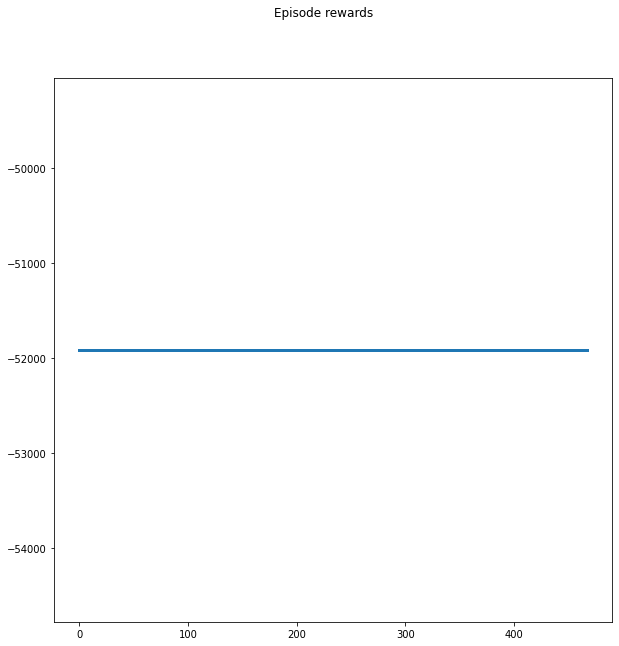

In [318]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(10,10))
fig.suptitle('Episode rewards')
ax.plot(np.arange(0,len(rewards[20:])),rewards[100:], linewidth = 3)

In [317]:
torch.save(policy_net.state_dict(), 'policy_net_angle_rew3.pth')

In [290]:
# action_dim = 1
# state_dim  = 6
# hidden_dim = 256

# pol_net = PolicyNetwork(state_dim, action_dim, hidden_dim).to(device)
# pol_net.load_state_dict(torch.load('policy_net_1_rw_system.pth'))

## Testing

In [322]:
state0 = np.array([0,np.pi/2,np.pi/2,
                0,0,0])
state = state0
state

array([0.        , 1.57079633, 1.57079633, 0.        , 0.        ,
       0.        ])

C:\ProgramData\Anaconda3\lib\site-packages\scipy\integrate\odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


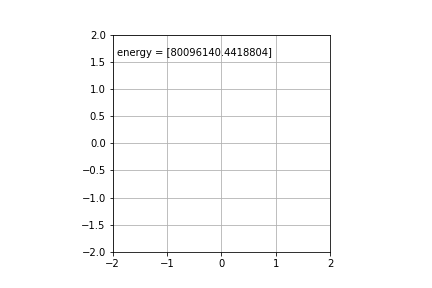

In [321]:
%matplotlib widget

state = state0

dt = 0.1
fig = plt.figure()
ax = fig.add_subplot(111, aspect='equal', autoscale_on=False,
                     xlim=(-2, 2), ylim=(-2, 2))
ax.grid()

line, = ax.plot([], [], 'o-', lw=2)
energy_text = ax.text(0.02, 0.90, '', transform=ax.transAxes)

def init():
    """initialize animation"""
    line.set_data([], [])
    #time_text.set_text('')
    energy_text.set_text('')
    return line


def animate(i):
    """perform animation step"""
    global state, dt
    state_t = torch.FloatTensor(state)
    u = policy_net(state_t)
    state = get_next_state(state,u[0].detach().numpy(),dt)
    XY = state_to_coords(state)
    en = get_energy(state)
    
    line.set_data(XY[0],XY[1])
    energy_text.set_text(f'energy = {en}')
    return line,

ani = animation.FuncAnimation(fig, animate, frames=100,
                             interval=10, blit=True, init_func=init)

from IPython.display import HTML
HTML(ani.to_jshtml())

In [167]:
state = state0
for i in range(0,270):
    
  state_t = torch.FloatTensor(state)
  u = pol_net(state_t)
  state = get_next_state(state,u[0].detach().numpy(),dt)
  print('_________________________')
  print('X coord', print(u))
  print('Pole 1 angle', np.degrees(state[1] % (2*np.pi)))
  print('Pole 2 angle', np.degrees(state[2] % (2*np.pi)))

_________________________
(tensor([-0.0271], grad_fn=<AddBackward0>), tensor([-1.7949], grad_fn=<ClampBackward1>))
X coord None
Pole 1 angle 89.9999224244191
Pole 2 angle 90.00000001676032
_________________________
(tensor([-0.0100], grad_fn=<AddBackward0>), tensor([-1.7996], grad_fn=<ClampBackward1>))
X coord None
Pole 1 angle 89.99973837305475
Pole 2 angle 90.00000021724517
_________________________
(tensor([-0.0035], grad_fn=<AddBackward0>), tensor([-1.8014], grad_fn=<ClampBackward1>))
X coord None
Pole 1 angle 89.9995145271755
Pole 2 angle 90.00000096112073
_________________________
(tensor([-0.0011], grad_fn=<AddBackward0>), tensor([-1.8021], grad_fn=<ClampBackward1>))
X coord None
Pole 1 angle 89.99927546564906
Pole 2 angle 90.00000270791953
_________________________
(tensor([-7.5717e-05], grad_fn=<AddBackward0>), tensor([-1.8024], grad_fn=<ClampBackward1>))
X coord None
Pole 1 angle 89.99903016438476
Pole 2 angle 90.00000593543628
_________________________
(tensor([0.0004], grad

_________________________
(tensor([0.0197], grad_fn=<AddBackward0>), tensor([-1.7991], grad_fn=<ClampBackward1>))
X coord None
Pole 1 angle 89.9645472084385
Pole 2 angle 90.03966225500035
_________________________
(tensor([0.0206], grad_fn=<AddBackward0>), tensor([-1.7989], grad_fn=<ClampBackward1>))
X coord None
Pole 1 angle 89.9630419814422
Pole 2 angle 90.0423319439461
_________________________
(tensor([0.0216], grad_fn=<AddBackward0>), tensor([-1.7986], grad_fn=<ClampBackward1>))
X coord None
Pole 1 angle 89.96146731135772
Pole 2 angle 90.04516026506847
_________________________
(tensor([0.0225], grad_fn=<AddBackward0>), tensor([-1.7984], grad_fn=<ClampBackward1>))
X coord None
Pole 1 angle 89.95981963944584
Pole 2 angle 90.04815602692065
_________________________
(tensor([0.0236], grad_fn=<AddBackward0>), tensor([-1.7981], grad_fn=<ClampBackward1>))
X coord None
Pole 1 angle 89.95809522114946
Pole 2 angle 90.05132851845882
_________________________
(tensor([0.0247], grad_fn=<AddBa

_________________________
(tensor([0.3139], grad_fn=<AddBackward0>), tensor([-0.4170], grad_fn=<ClampBackward1>))
X coord None
Pole 1 angle 89.41371671184528
Pole 2 angle 91.40462311817144
_________________________
(tensor([0.3168], grad_fn=<AddBackward0>), tensor([-0.3989], grad_fn=<ClampBackward1>))
X coord None
Pole 1 angle 89.38196378493588
Pole 2 angle 91.48194828050521
_________________________
(tensor([0.3231], grad_fn=<AddBackward0>), tensor([-0.3799], grad_fn=<ClampBackward1>))
X coord None
Pole 1 angle 89.34810145802884
Pole 2 angle 91.56346269609087
_________________________
(tensor([0.3323], grad_fn=<AddBackward0>), tensor([-0.3601], grad_fn=<ClampBackward1>))
X coord None
Pole 1 angle 89.31195935301962
Pole 2 angle 91.64939506158672
_________________________
(tensor([0.3334], grad_fn=<AddBackward0>), tensor([-0.3466], grad_fn=<ClampBackward1>))
X coord None
Pole 1 angle 89.27333896128529
Pole 2 angle 91.73998706669553
_________________________
(tensor([0.3315], grad_fn=<Ad

_________________________
(tensor([1.3645], grad_fn=<AddBackward0>), tensor([-0.5978], grad_fn=<ClampBackward1>))
X coord None
Pole 1 angle 76.64064033270856
Pole 2 angle 108.68156286850044
_________________________
(tensor([1.3799], grad_fn=<AddBackward0>), tensor([-0.6007], grad_fn=<ClampBackward1>))
X coord None
Pole 1 angle 75.87653224049306
Pole 2 angle 109.59961756625678
_________________________
(tensor([1.3920], grad_fn=<AddBackward0>), tensor([-0.6030], grad_fn=<ClampBackward1>))
X coord None
Pole 1 angle 75.08378633274016
Pole 2 angle 110.54924285204899
_________________________
(tensor([1.4150], grad_fn=<AddBackward0>), tensor([-0.6067], grad_fn=<ClampBackward1>))
X coord None
Pole 1 angle 74.26274374765569
Pole 2 angle 111.53001745189103
_________________________
(tensor([1.4413], grad_fn=<AddBackward0>), tensor([-0.6108], grad_fn=<ClampBackward1>))
X coord None
Pole 1 angle 73.41388269124218
Pole 2 angle 112.54143001603295
_________________________
(tensor([1.4669], grad_f

_________________________
(tensor([-0.7905], grad_fn=<AddBackward0>), tensor([-0.2051], grad_fn=<ClampBackward1>))
X coord None
Pole 1 angle 14.107207086656766
Pole 2 angle 175.57169495799158
_________________________
(tensor([-0.8587], grad_fn=<AddBackward0>), tensor([-0.1993], grad_fn=<ClampBackward1>))
X coord None
Pole 1 angle 12.104935315754018
Pole 2 angle 177.11410621653752
_________________________
(tensor([-0.9211], grad_fn=<AddBackward0>), tensor([-0.1935], grad_fn=<ClampBackward1>))
X coord None
Pole 1 angle 10.053325493545925
Pole 2 angle 178.64879216399612
_________________________
(tensor([-0.9654], grad_fn=<AddBackward0>), tensor([-0.1886], grad_fn=<ClampBackward1>))
X coord None
Pole 1 angle 7.950951451113063
Pole 2 angle 180.17680932703016
_________________________
(tensor([-0.9808], grad_fn=<AddBackward0>), tensor([-0.1860], grad_fn=<ClampBackward1>))
X coord None
Pole 1 angle 5.796466008375363
Pole 2 angle 181.69973909914196
_________________________
(tensor([-0.9807